# Spatial tendency

The aim of spatial tendency analysis is to assess whether expression features were influenced by spatial proximity to the region of interest. Expression features could be gene expression, pathway activity, cell proportion and so on. The region of interest could be defined by manual annotation or be automatically detected by the “Spatial Domain” function. Two kinds of methods, statistical test and regression model, were available for tendency estimation in the “Spatial Tendency” module.

Here we used 10X Visium data of mouse dorsolateral prefrontal cortex (DLPFC, 151676) as an example to validate the feasibility of spatial tendency estimation.

The raw data are available at https://github.com/LieberInstitute/spatialLIBD.
The processed data 1516761_10X_adata.h5ad is stored in https://zenodo.org/records/14588408.

## Read and preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import SOAPy_st as sp
import matplotlib.pyplot as plt

In [2]:
# input adata
adata = sc.read_h5ad('/csb2/project/SpatialPackage_whq/Tutorial/data/1516761_10X_adata.h5ad')

# delete genes with same names
adata.var_names_make_unique()

# preprocessing
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=2)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

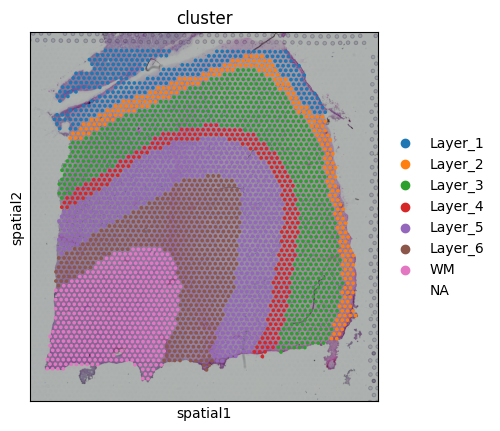

In [3]:
sc.pl.spatial(adata, img_key="hires", color='cluster')

## Generate a mask image from the domain cluster

To find genes whose spatial expression changes with the distance to white matter, white matter regions (ROI) are selected to construct a mask image used `sp.tl.get_mask_from_domain()`. *KSize* is the convolution kernel for the dilation and erosion operations of the image, which must be the odd number.

[11361 11260]


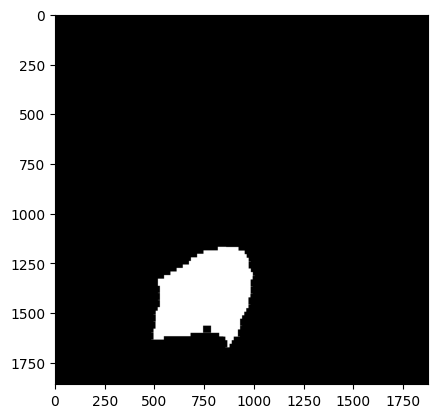

In [4]:
mask = sp.tl.get_mask_from_domain(adata, clusters='WM', KSize=35, cluster_key='cluster')
plt.imshow(mask, cmap='gray')
plt.show()

## Statstical testing

Cortical layers were divided into two regions before and use Wilcoxon test.

In [5]:
wilcoxon_res = sp.tl.wilcoxon_test(
    adata,
    mask,
    radius=1000,
    location='out',
    cut=500
)

In [6]:
wilcoxon_res.head()

,gene,stat,P value,effective spot near,effective spot far,P fdr,P rej
0,AL669831.5,1096392.0,0.003146,1234,1750,0.041365,True
1,LINC00115,1081393.0,0.397687,1234,1750,0.698975,False
2,FAM41C,1082177.0,0.358737,1234,1750,0.668305,False
3,SAMD11,1076975.0,0.384899,1234,1750,0.689967,False
4,NOC2L,1099105.0,0.185846,1234,1750,0.491811,False


Divide the surrounding areas of ROIs into continuous zones parallel to the shape of the boundary lines, and then calculate the Spearman correlation coefficients between the expression median of different zones and their distance ranks to the boundaries.

In [7]:
spearman_res = sp.tl.spearman_correlation(
    adata,
    mask,
    radius=1000,
    num=5
)

In [8]:
spearman_res.head()

,gene,coef,P value,P fdr,P rej
0,AL669831.5,0.032850,0.053347,0.125194,False
1,LINC00115,-0.011713,0.490979,0.639046,False
2,FAM41C,0.016004,0.346641,0.504274,False
3,SAMD11,-0.008111,0.633396,0.756434,False
4,NOC2L,0.046243,0.006516,0.023516,True


## Regression

To resolve more complex spatial tendency (e.g., nonlinear) or analyze ROIs without prior hypothesis, SOAPy provides a parameter regression method (polynomial regression) and a non-parametric regression method (LOESS regression).

Here we use the method of polynomial regression as an example.

In [9]:
sp.tl.spatial_tendency(
    adata,
    mask, # 
    radius=1000,
    location='out',
    frac=5
)

100%|█████████████████████████████████████████████████████████████████████████████████| 16120/16120 [00:57<00:00, 282.07it/s]


AnnData object with n_obs × n_vars = 3460 × 16120
    obs: 'in_tissue', 'array_row', 'array_col', 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'imagerow', 'imagecol'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells'
    uns: 'spatial', 'log1p', 'cluster_colors', 'SOAPy'
    obsm: 'spatial'

The regression method describes the continuous spatial variation of expression, therefore it could find more complex spatial patterns than other methods, such as nonlinear change “low-high-low”. **PCP4** is an example.

Using `show_tendency()` to display the spatial tendency of genes.

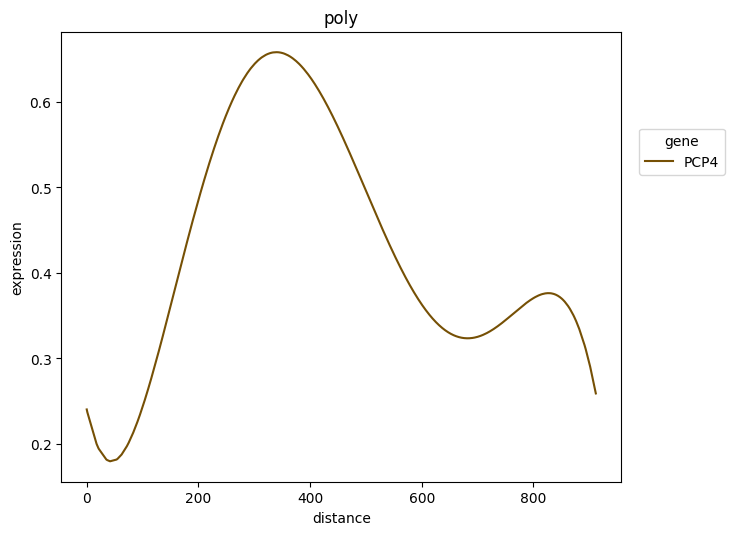

In [10]:
sp.pl.show_tendency(adata, gene_name = 'PCP4', show=True)

The real spatial distribution of **PCP4** is used for verification, and the results are consistent with the trend we find out.

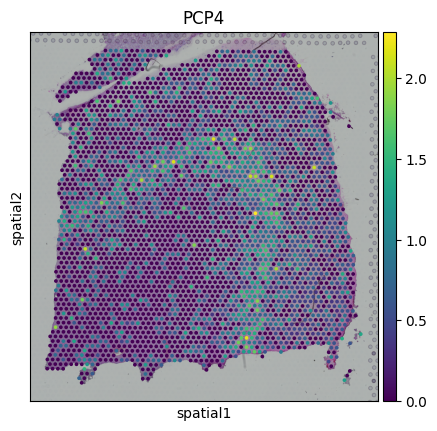

In [11]:
sc.pl.spatial(adata, img_key="hires", color='PCP4')

## Clustering genes based on regression curves

According to the similarity of the curves, the genes were clustered into 10 clusters, and the genes with similar expression distribution were summarized. 
`sp.tl.gene_cluster()` can cluster the curves of genes to obtain genes with similar spatial trends and `sp.pl.show_curves_cluster()`  shows the spatial trends of the clusters

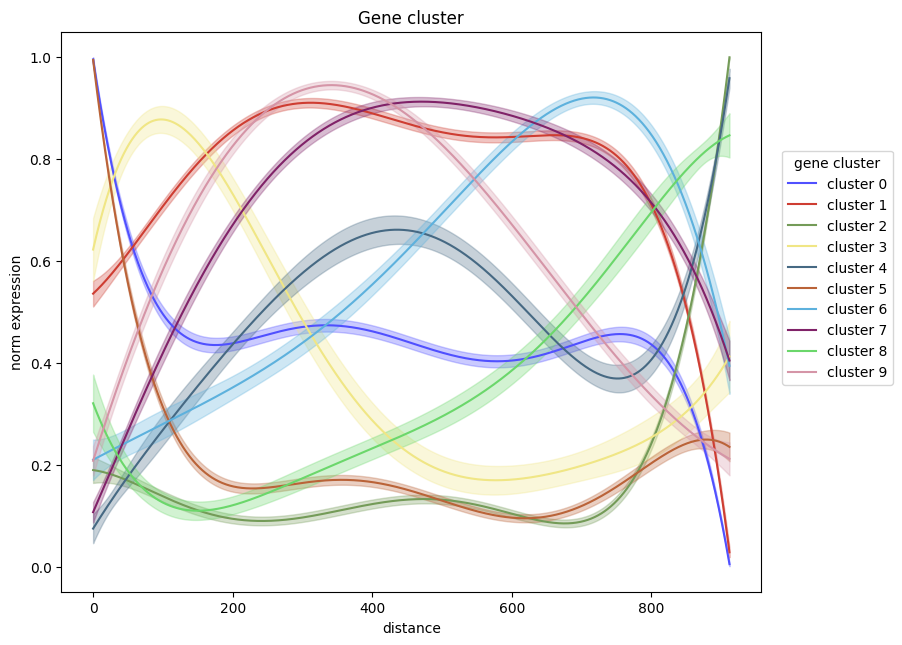

In [12]:
sp.tl.gene_cluster(adata=adata, k=10, range_min=0.03, fdr=True, pvalue=0.05)
sp.pl.show_curves_cluster(adata)

Display of regression results

In [13]:
adata.uns['SOAPy']['gene_cluster']['gene_cluster'].head()

,p_value,param,range,correlation,Spots number,AIC,BIC,p_adjust,p_rej,cluster
HES4,5.633775e-04,"[0.13264303892839413, -0.0006650334489480428, ...",0.101848,0.073997,2984,942.057636,978.063756,4.932996e-03,True,8
ISG15,1.319268e-14,"[0.22827756017707687, 0.0005260869480460644, -...",0.300578,-0.141283,2984,2178.311971,2214.318090,6.041649e-13,True,1
AL390719.2,1.297120e-09,"[0.0019080052657183982, 0.00029699148644908916...",0.106268,0.016078,2984,-8162.861969,-8126.855849,3.313721e-08,True,2
VWA1,9.577923e-13,"[0.2811533391077294, -0.0018370393852305462, 6...",0.197323,-0.090514,2984,798.482892,834.489012,3.582277e-11,True,5
FNDC10,2.519375e-03,"[0.014946894836472786, 0.0013003833923470607, ...",0.185635,0.023977,2984,84.695331,120.701451,1.725981e-02,True,4
